In [1]:
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
import mnist_reader
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import defaultdict
from scipy.spatial import distance
import os
import random as rand
# set matplotlib to display all plots inline with the notebook
%matplotlib inline

In [2]:
def float_compare(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

### Plot pixels

In [3]:
def display_digit(digit):
    """ 
    graphically displays a 784x1 vector, representing a digit
    """
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    #plt.savefig(fpath)

# K Means E and M Step

In [4]:
def centeroid_step(clusters,text):
    centeroids=[]
    for i in clusters:
        if text:
            nparr = np.array([j[0] for j in clusters[i]])
            mean1 = np.mean(nparr,axis=0)
            
            sim = np.matmul(nparr, mean1)
            ind = np.unravel_index(np.argmin(sim, axis=None), sim.shape)
           
            centeroids.append(nparr[ind[0]])
        else:    
            centeroids.append(np.mean(np.array([j[0] for j in clusters[i]]),axis=0))

    return centeroids

def clustering_step(k,centeroids,data,label,cosine):
    clusters={}
    for i in range(k):
        clusters[i]=[]    
    
    if(cosine):
        sim = cosine_distances(data,centeroids)
    else:
        sim = euclidean_distances(data,np.array(centeroids))
    
    c=0
    for i in sim:
        ind = np.unravel_index(np.argmin(i, axis=None), i.shape)
        clusters[ind[0]].append((data[c],label[c]))
        c+=1
    return clusters
        


# K Means

In [5]:
def Kmeans(k, data, label, cosine,text):
    centeroids=[]
    clusters={}
    
    for i in range(k):
        clusters[i]=[]
        
    for i in range(k):
        centeroids.append(data[rand.randint(0,len(label))])
            
    prev_centeroids = centeroids
    prev_clusters = clusters
    
    ctr = 0
    ch=0
    while(True):
        clusters = clustering_step(k,centeroids,data,label,cosine)
        centeroids = centeroid_step(clusters,text)
        
        pt=True
        #eud=[]
        for i in range(len(prev_centeroids)):
            #eud.append(distance.euclidean(prev_centeroids[i],centeroids[i]))
            for j in range(len(prev_centeroids[i])):
                if(not float_compare(prev_centeroids[i][j],centeroids[i][j])):
                    pt=False

        if(pt):
            break
        
        ch=0
        for i in clusters:
            ch+=abs(len(prev_clusters[i])-len(clusters[i]))
        if(ctr%10==0):
            print "round: ",ctr," number of shuffles: ",ch
        
        ctr+=1
        prev_centeroids = centeroids
        prev_clusters = clusters

    ch=0
    for i in clusters:
        ch+=abs(len(prev_clusters[i])-len(clusters[i]))
    if(ctr%10!=0):
        print "round: ",ctr," number of shuffles: ",ch

    return centeroids,clusters

In [41]:
def performance_calculator(cluster,categories):
    confusion_matrix=[]
    for i in cluster:
        countDict=defaultdict(int)
        for j in cluster[i]:
            countDict[j[1]]+=1
    
        confusion_matrix.append([countDict[i] for i in range(categories)])
    
    print np.array(confusion_matrix).shape
    numerator = 0
    denominator = 0
    for i in confusion_matrix:
        numerator+=max(i)
        denominator+=sum(i)
    
    purity = float(numerator)/float(denominator)
    
    gini_indexes=[]
    total=0
    for i in confusion_matrix:
        gi=1
        for j in i:
            gi-=((float(j)/float(sum(i)))**2)
        gini_indexes.append(gi*sum(i))
        total+=sum(i)
        
    gini = float(sum(gini_indexes))/float(total)
    
    return (purity,gini,confusion_matrix)

In [42]:
def runKmeans(k,X,y,nl,image=False,cosine=False,Text=False):
    centeroids,clusters = Kmeans(k,X,y,cosine,Text)
    purity,gini,confusion_matrix = performance_calculator(clusters,nl)
    
    if image:
        for i in centeroids:
            display_digit(i)
    
    print "Purity: ",purity
    print "Gini: ",gini
    print "Confusion Matrix: ",display(pd.DataFrame(confusion_matrix))

# Mnist Data

In [43]:
mnist = fetch_mldata('MNIST original', data_home="/Users/sasankauppu/Desktop/Data Mining CS6220/")
mnist_X = mnist.data
mnist_y = mnist.target
del(mnist)

round:  0  number of shuffles:  70000
round:  10  number of shuffles:  494
round:  20  number of shuffles:  96
round:  30  number of shuffles:  50
round:  40  number of shuffles:  42
round:  50  number of shuffles:  24
round:  60  number of shuffles:  8
round:  65  number of shuffles:  0
(10, 10)
Purity:  0.588685714286
Gini:  0.537598646738
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9
0,3,6,64,36,1838,166,1,3137,205,1852
1,9,57,4859,186,15,7,65,49,51,8
2,20,35,54,159,1803,315,6,2870,162,2852
3,59,19,216,954,9,1008,33,12,4037,53
4,9,7718,820,405,254,583,413,442,649,181
5,49,9,207,97,2657,253,162,755,147,1849
6,4770,0,50,23,2,55,80,13,36,41
7,269,12,327,4658,0,2123,33,3,1169,91
8,179,13,157,38,123,86,4785,4,51,8
9,1536,8,236,585,123,1717,1298,8,318,23


 None


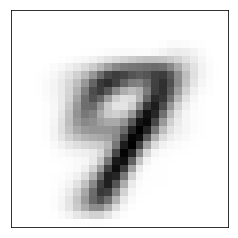

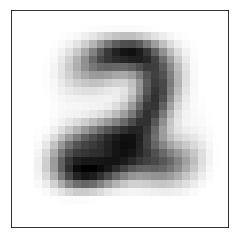

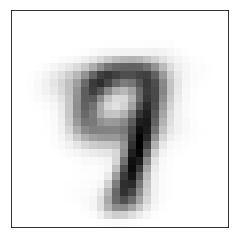

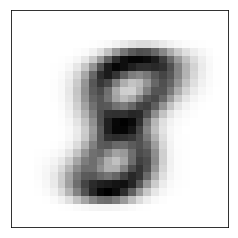

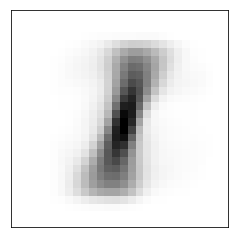

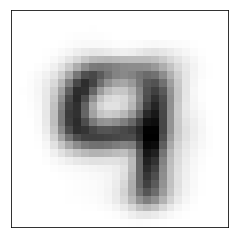

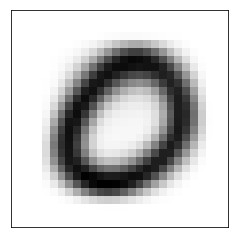

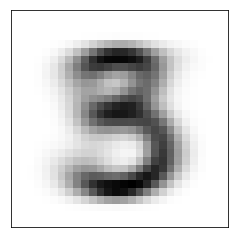

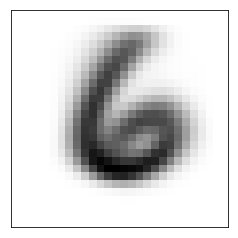

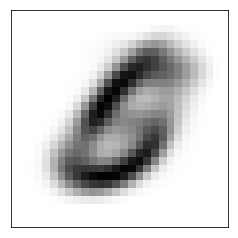

In [44]:
### K=10
runKmeans(10,mnist_X,mnist_y,10,True)

round:  0  number of shuffles:  70000
round:  10  number of shuffles:  1132
round:  20  number of shuffles:  512
round:  30  number of shuffles:  240
round:  40  number of shuffles:  142
round:  50  number of shuffles:  134
round:  60  number of shuffles:  94
round:  70  number of shuffles:  22
round:  80  number of shuffles:  2
round:  85  number of shuffles:  0
Purity:  0.390042857143
Gini:  0.728934152137
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9
0,5782,7,532,4565,2,2946,162,13,1658,94
1,54,16,200,541,3854,624,69,2707,611,3704
2,199,21,188,392,2285,1372,5,3970,2478,2810
3,827,16,4620,231,343,209,5880,25,258,72
4,41,7817,1450,1412,340,1162,760,578,1820,278


 None


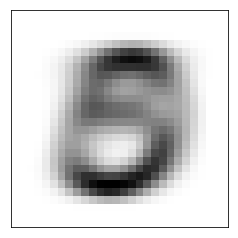

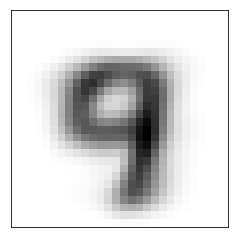

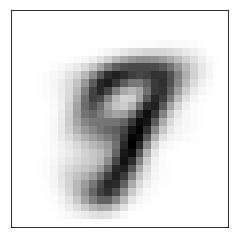

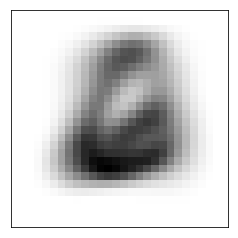

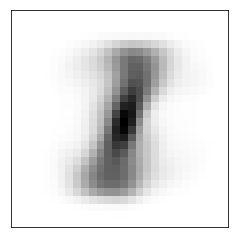

In [12]:
### K=5
runKmeans(5,mnist_X,mnist_y,10,True)

round:  0  number of shuffles:  70000
round:  10  number of shuffles:  714
round:  20  number of shuffles:  288
round:  30  number of shuffles:  344
round:  40  number of shuffles:  146
round:  50  number of shuffles:  96
round:  60  number of shuffles:  138
round:  70  number of shuffles:  64
round:  80  number of shuffles:  18
round:  90  number of shuffles:  4
Purity:  0.712642857143
Gini:  0.406573521418
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9
0,50,8,112,219,4,308,5,12,2609,20
1,49,1,81,2398,0,638,7,0,136,19
2,2,11,72,31,244,21,0,2715,82,1201
3,0,2858,95,55,38,18,26,97,67,60
4,0,2804,98,31,42,10,54,153,62,29
5,255,15,237,122,412,1895,278,86,282,87
6,228,7,69,20,90,81,3428,0,20,3
7,119,3,45,10,55,30,2733,3,18,8
8,9,1,99,37,2064,128,32,396,55,1561
9,2889,0,10,9,2,22,44,7,20,18


 None


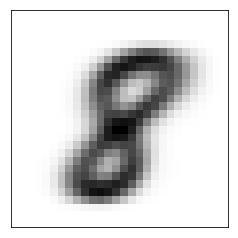

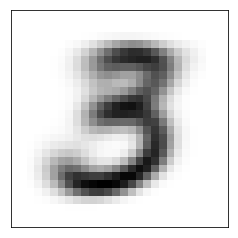

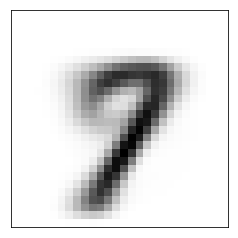

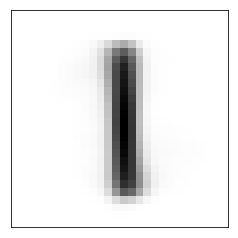

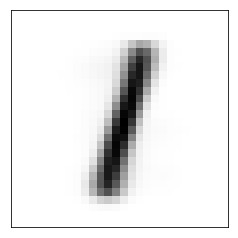

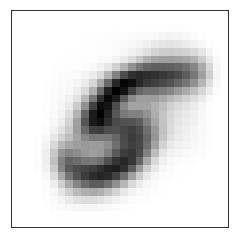

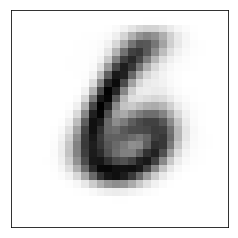

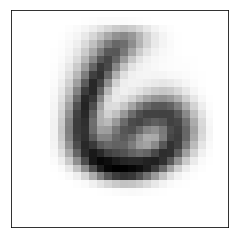

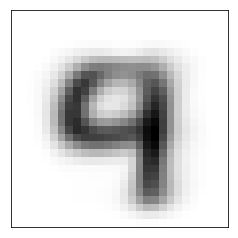

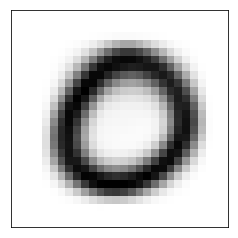

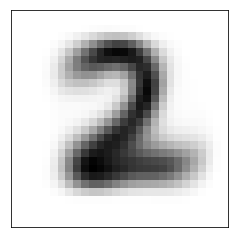

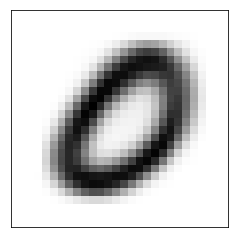

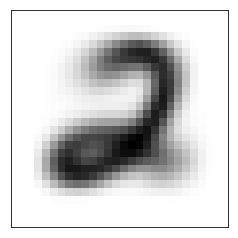

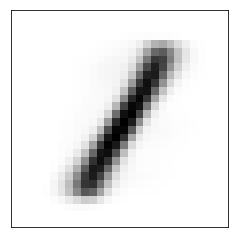

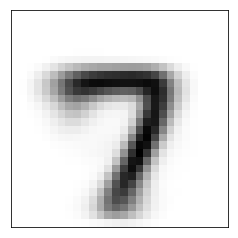

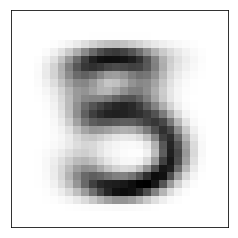

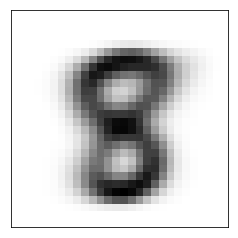

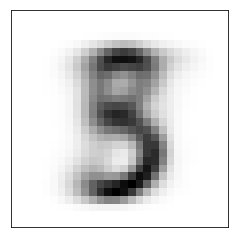

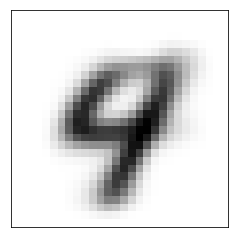

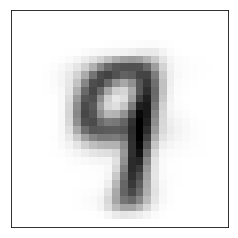

In [13]:
### K=20
runKmeans(20,mnist_X,mnist_y,10,True)

In [18]:
del(mnist_X)
del(mnist_y)

# Fashion Data

In [14]:
X_train, y_train = mnist_reader.load_mnist('data/', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/', kind='t10k')

fashion_X = np.concatenate((X_train,X_test))
fashion_y = np.concatenate((y_train,y_test))

del(X_train)
del(X_test)
del(y_train)
del(y_test)

round:  0  number of shuffles:  70000
round:  10  number of shuffles:  2594
round:  20  number of shuffles:  246
round:  30  number of shuffles:  170
round:  40  number of shuffles:  190
round:  50  number of shuffles:  1452
round:  60  number of shuffles:  74
round:  70  number of shuffles:  40
round:  80  number of shuffles:  26
round:  90  number of shuffles:  20
round:  100  number of shuffles:  6
round:  110  number of shuffles:  4
round:  120  number of shuffles:  8
round:  128  number of shuffles:  0
Purity:  0.538328571429
Gini:  0.572463771437
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9
0,4,0,1,0,0,1256,4,5422,189,248
1,81,4,166,16,76,5035,233,853,381,343
2,0,0,0,0,0,334,1,35,7,3540
3,31,0,19,7,28,11,17,0,2941,2
4,4162,274,123,1927,986,2,1296,0,24,3
5,12,0,12,2,8,288,22,690,2294,2809
6,183,48,3392,40,3443,0,1840,0,479,1
7,2136,605,1066,1622,629,72,1880,0,541,38
8,165,5984,10,3239,172,1,52,0,8,1
9,226,85,2211,147,1658,1,1655,0,136,15


 None


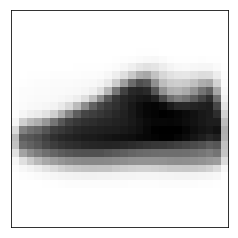

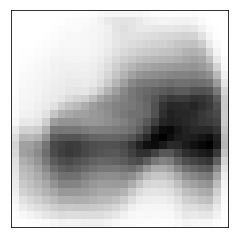

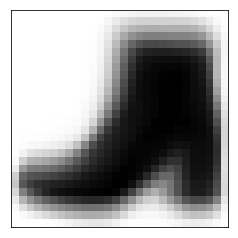

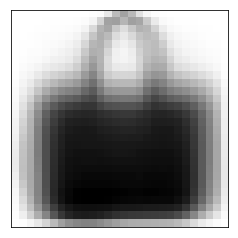

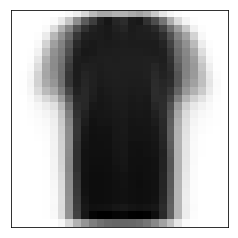

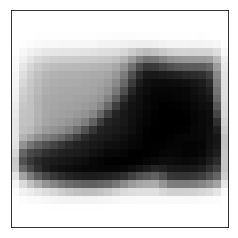

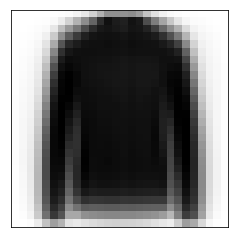

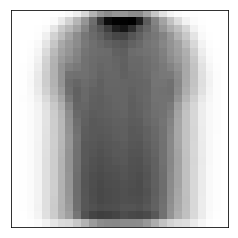

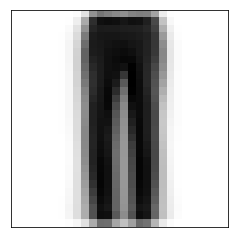

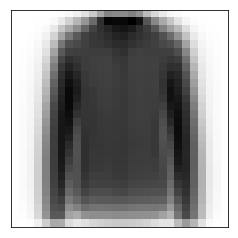

In [15]:
### K=10
runKmeans(10,fashion_X,fashion_y,10,True)

round:  0  number of shuffles:  70000
round:  10  number of shuffles:  974
round:  20  number of shuffles:  88
Purity:  0.4262
Gini:  0.665706239642
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9
0,3175,6680,287,5883,923,16,1310,0,340,35
1,2759,145,4959,539,5304,0,3617,0,331,31
2,992,170,1571,563,676,6287,1849,6172,1158,517
3,0,0,0,0,0,680,2,813,22,6414
4,74,5,183,15,97,17,222,15,5149,3


 None


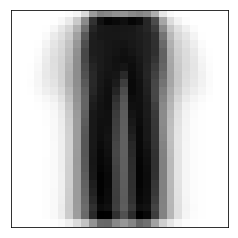

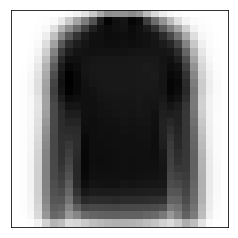

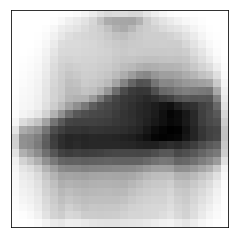

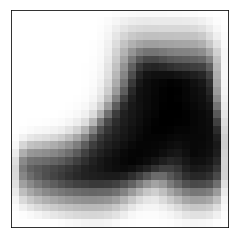

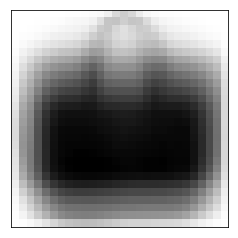

In [16]:
### K=5
runKmeans(5,fashion_X,fashion_y,10,True)

round:  0  number of shuffles:  70000
round:  10  number of shuffles:  1342
round:  20  number of shuffles:  398
round:  30  number of shuffles:  364
round:  40  number of shuffles:  224
round:  50  number of shuffles:  128
round:  60  number of shuffles:  22
round:  70  number of shuffles:  4
round:  77  number of shuffles:  0
Purity:  0.6592
Gini:  0.44014459477
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9
0,7,20,1659,0,1584,0,325,0,3,0
1,11,0,10,0,12,5,7,0,1557,1
2,0,0,0,0,0,103,0,13,2,2179
3,1,0,2,0,1,1727,6,7,47,167
4,3621,3,23,62,6,0,749,0,4,0
5,38,1,14,29,19,9,22,0,1610,2
6,156,340,9,3259,64,4,50,0,23,6
7,5,0,10,1,1,1528,27,359,398,351
8,22,0,31,3,16,2683,38,877,74,7
9,270,81,1968,145,1050,2,1624,0,106,12


 None


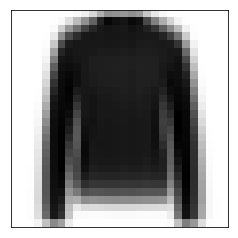

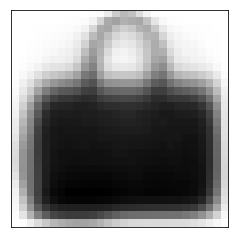

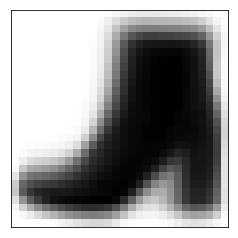

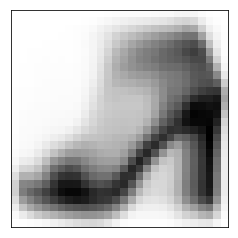

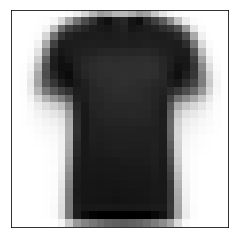

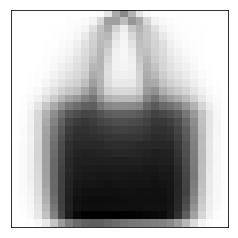

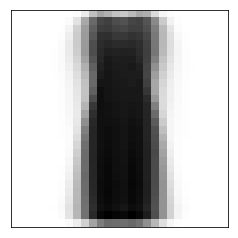

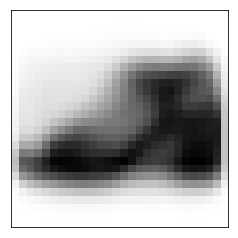

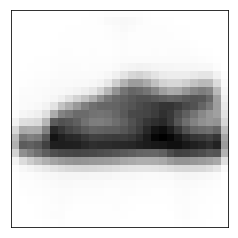

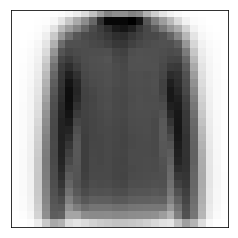

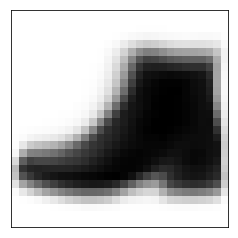

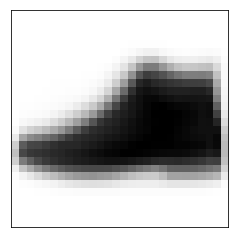

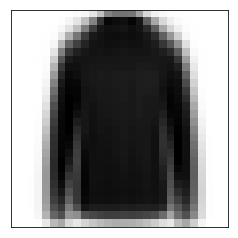

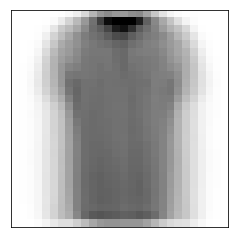

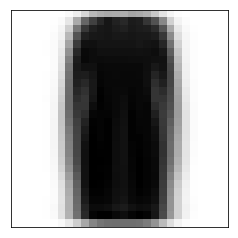

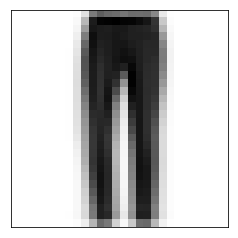

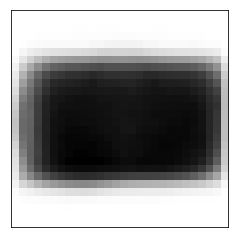

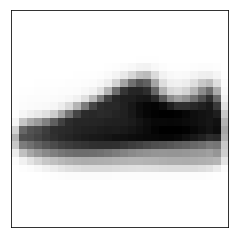

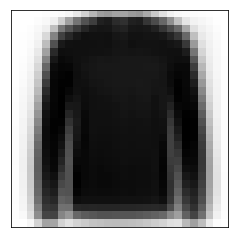

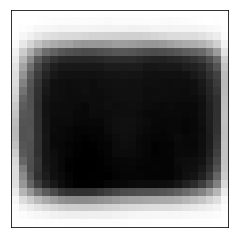

In [17]:
### K=20
runKmeans(20,fashion_X,fashion_y,10,True)

In [19]:
del(fashion_X)
del(fashion_y)

# News Groups Data

In [38]:
ng = fetch_20newsgroups(subset='all')
ng_X = ng.data
ng_y = ng.target

del(ng)
count_vect = CountVectorizer(stop_words="english",min_df=3,max_df=0.5)
ng_X = count_vect.fit_transform(ng_X)

tfidf_transformer = TfidfTransformer(use_idf=True)
ng_X = tfidf_transformer.fit_transform(ng_X)

print ng_X.shape

(18846, 52290)


In [39]:
ng_X = np.asarray(ng_X.todense())

In [40]:
### K=20
runKmeans(20,ng_X,ng_y,20,False,True,False)

round:  0  number of shuffles:  18846
round:  10  number of shuffles:  122
round:  20  number of shuffles:  38
round:  30  number of shuffles:  32
round:  40  number of shuffles:  10
round:  50  number of shuffles:  28
round:  60  number of shuffles:  4
round:  68  number of shuffles:  0
Purity:  0.377480632495
Gini:  0.740101848621
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,439,710,259,178,276,73,3,1,1,0,17,89,6,7,2,2,2,0,0
1,190,12,15,36,37,6,16,33,14,11,6,0,18,16,9,3,25,17,27,46
2,3,8,12,3,12,7,23,8,10,14,0,8,13,424,12,4,16,8,21,8
3,0,9,2,4,3,1,2,8,4,10,9,4,2,140,9,0,12,10,9,8
4,15,49,25,25,45,383,21,38,14,14,36,11,49,25,28,26,6,2,7,9
5,3,0,0,0,0,0,0,0,3,0,0,1,1,0,1,39,0,0,183,5
6,21,41,11,29,21,14,52,52,42,47,71,10,38,16,7,7,26,19,32,26
7,2,4,0,1,1,0,0,0,1,5,0,0,2,2,0,5,3,506,5,8
8,4,14,7,10,31,10,67,57,47,17,10,14,30,18,3,5,16,3,39,4
9,8,14,7,11,12,18,14,6,4,16,0,761,21,9,9,4,108,3,39,3


 None


In [35]:
### K=10
runKmeans(10,ng_X,ng_y,20,False,True,False)

round:  0  number of shuffles:  18846
round:  10  number of shuffles:  156
round:  20  number of shuffles:  60
round:  30  number of shuffles:  32
round:  40  number of shuffles:  4
round:  42  number of shuffles:  0
Purity:  0.348190597474
Gini:  0.762657073714
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,19,37,24,47,32,17,21,33,26,37,1,131,48,55,36,22,71,5,45,27
1,171,55,36,65,40,60,90,549,140,88,23,70,214,373,44,47,255,58,122,128
2,3,26,12,19,15,30,8,24,19,6,4,31,57,35,784,9,6,0,34,7
3,1,1,0,5,3,1,22,1,1,768,930,1,9,2,1,1,0,2,2,1
4,62,95,40,97,160,46,590,219,47,77,36,36,285,336,55,23,74,86,134,65
5,473,15,14,1,1,0,2,19,10,6,3,41,2,91,20,857,474,778,306,373
6,3,5,2,5,17,7,13,105,703,5,0,6,34,29,6,3,6,0,4,7
7,0,73,139,607,609,8,182,4,0,1,0,2,127,1,3,2,3,1,0,0
8,63,59,24,24,22,56,6,24,48,2,1,646,83,40,21,22,19,7,128,15
9,4,607,694,112,64,763,41,12,2,4,1,27,125,28,17,11,2,3,0,5


 None


In [36]:
### K=40
runKmeans(40,ng_X,ng_y,20,False,True,False)

round:  0  number of shuffles:  18846
round:  10  number of shuffles:  144
round:  20  number of shuffles:  34
round:  30  number of shuffles:  4
round:  37  number of shuffles:  0
Purity:  0.493261169479
Gini:  0.63238089263
Confusion Matrix: 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3,5,2,17,19,5,14,22,19,3,7,2,251,48,11,1,4,0,0,4
1,0,3,3,8,10,15,5,6,15,19,6,14,8,97,12,2,30,8,11,2
2,245,11,1,4,1,3,0,5,2,6,3,0,10,1,8,3,10,8,4,26
3,31,2,3,2,11,3,13,3,7,2,1,3,13,6,20,6,7,75,8,5
4,5,4,7,2,7,4,8,5,5,6,4,2,2,279,5,2,2,4,2,5
5,9,27,3,9,18,7,11,18,4,31,6,2,23,12,10,4,6,0,6,10
6,1,1,1,1,0,12,1,0,0,0,0,585,4,0,1,0,2,0,3,0
7,0,1,4,23,38,11,7,3,3,24,31,1,14,20,1,19,0,0,1,5
8,60,98,33,26,25,98,5,16,60,2,2,43,54,23,25,16,14,3,9,15
9,2,10,1,0,7,13,11,12,16,8,7,3,8,30,5,2,5,136,24,15


 None
